In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

df = pd.read_excel("DatasetTrainingMatif20250812.xlsx")
df = df.rename(columns={'Period': 'date'})
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.sort_index()
dup_count = df.index.duplicated(keep=False).sum()
print(f"Duplicate timestamps: {dup_count}")
df = df[~df.index.duplicated(keep='last')]
df = df.asfreq('B')
df = df.ffill()
df

Duplicate timestamps: 4


,Month,Supply_to_Demand_World_Less_China_CoarseGrains,Consumption_per_Capita_US_Wheat_+_CoarseGrains,Consumption_per_Capita_MEwUS_CornFeed,Consumption_To_Production_ME_CoarseGrains,Consumption_To_Production_MEwoEU_CoarseGrains,Supply_per_Capita_MEwoEU_Corn,Supply_to_Demand_MIwoChina_CoarseGrains,Stock_to_Use_MIwoChina_CoarseGrains,Stock_per_Capita_MIwoChina_CoarseGrains,...,Consumption_per_Capita_EU_WheatFeed,Consumption_per_Capita_China_WheatFeed,Oil_Average_Prices,GDP_deflator,Long_term_interest_rates,Short_term_interest_rates,US_Dollar_Index,Bonds_Price_Spread_10Y_3M,Bonds_Price_Spread_10Y_2Y,Matif_Prices
date,,,,,,,,,,,,,,,,,,,,,
1998-08-12,8.0,1.130764,623.419969,432.058645,0.677776,0.677776,374.363903,1.150727,0.168392,32.438725,...,113.860425,3.996512,12.71,100.000000,4.425238,3.50,101.79,0.387,0.085,116.01
1998-08-13,8.0,1.130764,623.419969,432.058645,0.677776,0.677776,374.363903,1.150727,0.168392,32.438725,...,113.860425,3.996512,13.21,100.000000,4.425238,3.50,101.55,0.396,0.062,118.15
1998-08-14,8.0,1.130764,623.419969,432.058645,0.677776,0.677776,374.363903,1.150727,0.168392,32.438725,...,113.860425,3.996512,13.35,100.000000,4.425238,3.50,102.35,0.378,0.073,118.15
1998-08-17,8.0,1.130764,623.419969,432.058645,0.677776,0.677776,374.363903,1.150727,0.168392,32.438725,...,113.860425,3.996512,13.20,100.000000,4.425238,3.50,102.13,0.410,0.068,118.61
1998-08-18,8.0,1.130764,623.419969,432.058645,0.677776,0.677776,374.363903,1.150727,0.168392,32.438725,...,113.860425,3.996512,12.92,100.000000,4.425238,3.50,102.35,0.349,0.072,118.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-06,8.0,1.076077,459.565455,293.514016,0.615644,0.615644,516.231018,1.092432,0.095258,18.367494,...,102.970202,23.278097,64.35,163.768123,2.630000,1.99,98.18,-0.100,0.530,193.75
2025-08-07,8.0,1.076077,459.565455,293.514016,0.615644,0.615644,516.231018,1.092432,0.095258,18.367494,...,102.970202,23.278097,63.88,163.768123,2.630000,1.99,98.40,-0.090,0.510,197.50
2025-08-08,8.0,1.076077,459.565455,293.514016,0.615644,0.615644,516.231018,1.092432,0.095258,18.367494,...,102.970202,23.278097,63.88,163.768123,2.630000,1.99,98.18,-0.050,0.510,196.50


In [2]:
wx_all = pd.read_csv("matif_wx_daily_all.csv")
wx_all.drop(columns=["number", "step", "surface"], inplace=True)

df_weather = wx_all.copy()
df_weather["date"] = pd.to_datetime(df_weather["date"])
df_weather = df_weather.set_index("date").sort_index()

# Daily flags
df_weather["rainday"]  = (df_weather["precip_mm"] >= 1).astype(int)
df_weather["dryday"]   = (df_weather["precip_mm"] < 1).astype(int)
df_weather["heat32"]   = (df_weather["tmax"] >= 32).astype(int)
df_weather["heat35"]   = (df_weather["tmax"] >= 35).astype(int)
df_weather["frost0"]   = (df_weather["tmin"] < 0).astype(int)
df_weather["frostm5"]  = (df_weather["tmin"] <= -5).astype(int)
df_weather["gdd5"]     = (df_weather["tmean"] - 5).clip(lower=0)

# Rolling windows (7/14/30/60 as needed)
for w in [14, 30, 60]:
    df_weather[f"r{w}_precip"]   = df_weather["precip_mm"].rolling(w, min_periods=1).sum()
    df_weather[f"r{w}_tmean"]    = df_weather["tmean"].rolling(w, min_periods=1).mean()
    df_weather[f"heat32_{w}"]    = df_weather["heat32"].rolling(w, min_periods=1).sum()
    df_weather[f"frost0_{w}"]    = df_weather["frost0"].rolling(w, min_periods=1).sum()
    df_weather[f"frostm5_{w}"]   = df_weather["frostm5"].rolling(w, min_periods=1).sum()
    df_weather[f"raindays_{w}"]  = df_weather["rainday"].rolling(w, min_periods=1).sum()
    df_weather[f"drydays_{w}"]   = df_weather["dryday"].rolling(w, min_periods=1).sum()

# Current dry spell length
is_dry = df_weather["dryday"]
df_weather["dry_spell_current"] = is_dry.groupby((is_dry != is_dry.shift()).cumsum()).cumsum() * is_dry

# Crop-year cumulators
# crop year for sowing moisture: Oct 1 → Sep 30
crop_year_oct = np.where((df_weather.index.month >= 10), df_weather.index.year + 1, df_weather.index.year)
df_weather["precip_since_Oct1"] = pd.Series(crop_year_oct, index=df_weather.index).groupby(crop_year_oct).transform(lambda g: 0)
df_weather["precip_since_Oct1"] = df_weather.groupby(crop_year_oct)["precip_mm"].cumsum()

# GDD since Mar 1 (active growth)
year_mar = np.where((df_weather.index.month >= 3), df_weather.index.year, df_weather.index.year - 1)
df_weather["gdd5_since_Mar1"] = df_weather.groupby(year_mar)["gdd5"].cumsum()

# Simple anomalies (monthly)
df_weather["tmean_month_anom"] = df_weather["tmean"] - df_weather.groupby(df_weather.index.month)["tmean"].transform("mean")
df_weather["r30_precip_anom"]  = df_weather["r30_precip"] - df_weather.groupby(df_weather.index.month)["r30_precip"].transform("mean")

# (optional) Weekly features + lags for price modeling
wk = (df_weather
      .resample("W-MON")  # Monday weeks
      .agg({
          "tmean":"mean","tmin":"mean","tmax":"mean",
          "precip_mm":"sum",
          "r14_precip":"last","r30_precip":"last","r60_precip":"last",
          "r14_tmean":"last","r30_tmean":"last",
          "gdd5_since_Mar1":"last","precip_since_Oct1":"last",
          "heat32_30":"last","frost0_30":"last",
          "dry_spell_current":"last",
          "tmean_month_anom":"last","r30_precip_anom":"last",
      }))
# Example lags (in weeks)
for k in [1, 2, 4]:
    wk[f"r30_precip_lag{k}"] = wk["r30_precip"].shift(k)
    wk[f"r30_tmean_lag{k}"]  = wk["r30_tmean"].shift(k)

df_weather


,tmean,tmin,tmax,precip_mm,rainday,dryday,heat32,heat35,frost0,frostm5,...,heat32_60,frost0_60,frostm5_60,raindays_60,drydays_60,dry_spell_current,precip_since_Oct1,gdd5_since_Mar1,tmean_month_anom,r30_precip_anom
date,,,,,,,,,,,,,,,,,,,,,
1998-01-01,5.507969,3.638208,7.663111,4.226783,1,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0,4.226783,0.507969,2.075106,-80.773642
1998-01-02,6.753740,5.281315,8.065228,7.590326,1,0,0,0,0,0,...,0.0,0.0,0.0,2.0,0.0,0,11.817109,2.261709,3.320878,-73.183316
1998-01-03,7.253953,5.260826,9.748488,8.148474,1,0,0,0,0,0,...,0.0,0.0,0.0,3.0,0.0,0,19.965583,4.515663,3.821091,-65.034842
1998-01-04,6.090335,4.445637,7.913127,4.545515,1,0,0,0,0,0,...,0.0,0.0,0.0,4.0,0.0,0,24.511098,5.605998,2.657473,-60.489327
1998-01-05,5.698347,3.922430,7.358694,6.703269,1,0,0,0,0,0,...,0.0,0.0,0.0,5.0,0.0,0,31.214367,6.304345,2.265484,-53.786059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-11,20.671950,14.492672,26.701948,0.199757,0,1,0,0,0,0,...,0.0,0.0,0.0,42.0,18.0,6,735.114622,1443.141760,2.719800,2.268861
2025-08-12,21.915293,15.840702,28.173054,0.165101,0,1,0,0,0,0,...,0.0,0.0,0.0,41.0,19.0,7,735.279723,1460.057053,3.963143,0.295540
2025-08-13,22.409365,16.991938,28.368727,0.220523,0,1,0,0,0,0,...,0.0,0.0,0.0,40.0,20.0,8,735.500246,1477.466418,4.457215,-1.737518


In [3]:
df1 = pd.read_csv("matif.csv")
df1.rename(columns={"Price": "Close", "Vol.": "Volume", "Date": "date"}, inplace=True)
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.set_index('date')
df1.sort_index()
def convert_volume(x):
    if pd.isna(x) or x == "":
        return 0.0
    x = str(x).strip()
    if x.endswith("K"):
        return float(x[:-1]) #* 1_000
    return float(x)

df1["Volume"] = df1["Volume"].apply(convert_volume)
df1

,Year,Month,Close,Open,High,Low,Volume,Change %
date,,,,,,,,
1998-03-30,1998,3,125.01,125.16,125.16,125.01,0.04,0.00%
1998-03-31,1998,3,125.16,125.01,125.16,125.01,0.06,0.12%
1998-04-01,1998,4,125.01,125.01,125.01,125.01,0.01,-0.12%
1998-04-02,1998,4,124.86,124.86,124.86,124.86,0.03,-0.12%
1998-04-03,1998,4,123.64,124.55,124.55,123.64,0.15,-0.98%
...,...,...,...,...,...,...,...,...
2025-02-24,2025,2,224.50,226.00,226.50,224.50,16.51,-0.99%
2025-02-25,2025,2,225.00,225.00,226.50,223.75,12.75,0.22%
2025-02-26,2025,2,223.00,226.00,227.50,222.50,12.96,-0.89%


In [4]:
horizon = 10 # try weekly returns (5 trading days)
def make_ohlcv_features_no_leak(df, h=10):
    """
    df columns: Open, High, Low, Close, Volume
    Returns features aligned so row t uses info up to t-1 (via final shift).
    """
    out = pd.DataFrame(index=df.index)

    # --- Parkinson (efficient realized vol) ---
    # sqrt of rolling mean of log(H/L)^2; allow partial windows to reduce early NaNs
    hl2 = np.log(df['High'] / df['Low']).pow(2)
    out['parkinson_20'] = hl2.rolling(20, min_periods=10).mean().pow(0.5)

    # --- ATR (scaled) ---
    prev_close = df['Close'].shift(1)
    tr = pd.concat([
        (df['High'] - df['Low']).abs(),
        (df['High'] - prev_close).abs(),
        (df['Low']  - prev_close).abs()
    ], axis=1).max(axis=1)
    out['atr_14'] = (tr.rolling(14, min_periods=7).mean() / df['Close']).replace([np.inf, -np.inf], np.nan)

    # --- Volume surprise (z-score) ---
    vol = df['Volume'].astype(float)
    # if there are zeros/missing, forward-fill a little to avoid zero-std windows
    vol = vol.replace(0, np.nan).ffill(limit=3)
    vmean = vol.rolling(20, min_periods=10).mean()
    vstd  = vol.rolling(20, min_periods=10).std()
    vstd  = vstd.replace(0, np.nan)  # avoid division by zero
    out['vol_z20'] = ((vol - vmean) / vstd).fillna(0.0)  # conservative: treat undefined z as 0

    # --- Candlestick shape ---
    body   = (df['Close'] - df['Open']).abs()
    rng    = (df['High']  - df['Low']).abs()
    denom  = rng.replace(0, np.nan)
    out['body_to_range'] = (body / denom).fillna(0.0).clip(0, 5)

    # IMPORTANT: shift features by +1 so row t uses info up to t-1
    out = out.shift(1).dropna()
    return out


ohlcv_feats = make_ohlcv_features_no_leak(df1, horizon)
ohlcv_feats

,parkinson_20,atr_14,vol_z20,body_to_range
date,,,,
1998-04-15,0.002986,0.004330,-0.408012,0.000000
1998-04-16,0.003053,0.004366,1.550780,1.000000
1998-04-17,0.003006,0.004204,-0.907453,1.000000
1998-04-20,0.002888,0.004078,-1.042955,0.000000
1998-04-21,0.002783,0.003878,-0.968084,0.000000
...,...,...,...,...
2025-02-24,0.016898,0.017168,-1.853837,0.333333
2025-02-25,0.016706,0.017022,-1.496486,0.750000
2025-02-26,0.016269,0.015794,-1.513049,0.000000


In [5]:
import numpy as np
import pandas as pd
from arch import arch_model

# Option A: use the GARCH daily vol we built earlier (preferred)
# Daily log returns
price = df['Matif_Prices'].sort_index()
ret_d = np.log(price / price.shift(1)).dropna() * 100  # in percent for arch

# Fit GARCH(1,1) once on full series (fast version)
am = arch_model(ret_d, mean='Zero', vol='GARCH', p=1, q=1, dist='t')
res = am.fit(disp='off')

# Conditional volatility (in percent) → back to decimal
vol_garch = res.conditional_volatility / 100
vol_garch = vol_garch.reindex(price.index)
vol_garch.name = "vol_garch"

# Use shifted vol (t-1) so no look-ahead
vol_ref = vol_garch.shift(1)

# Thresholds (percentiles of historical vol)
low_thr  = vol_ref.quantile(0.50)
high_thr = vol_ref.quantile(0.70)

def label_regime(series, low=low_thr, high=high_thr):
    reg = pd.Series(index=series.index, dtype='object')
    state = 'CALM'
    for t in series.index:
        v = series.loc[t]
        if pd.isna(v):
            reg.loc[t] = np.nan
            continue
        if state == 'CALM' and v >= high:
            state = 'VOL'
        elif state == 'VOL' and v <= low:
            state = 'CALM'
        reg.loc[t] = state
    return reg

regime_garch = label_regime(vol_ref)


# Option B: quick realized daily vol proxy (if you don't have GARCH handy)
price = df['Matif_Prices'].sort_index()
dret = np.log(price / price.shift(1))
vol_daily = dret.rolling(20).std()  # 20d realized vol proxy

# --- Regime thresholds (hysteresis to avoid chattering) ---
# We decide regime at time t using vol at t-1 (info-timeliness)
vol_ref = vol_daily.shift(1)

low_thr  = vol_ref.quantile(0.50)   # calm if vol <= low_thr
high_thr = vol_ref.quantile(0.70)   # volatile if vol >= high_thr  (tune these)

def label_regime(series, low=low_thr, high=high_thr):
    reg = pd.Series(index=series.index, dtype='object')
    state = 'CALM'
    for t in series.index:
        v = series.loc[t]
        if pd.isna(v):
            reg.loc[t] = np.nan
            continue
        if state == 'CALM' and v >= high:
            state = 'VOL'
        elif state == 'VOL' and v <= low:
            state = 'CALM'
        reg.loc[t] = state
    return reg

regime = label_regime(vol_ref).dropna()


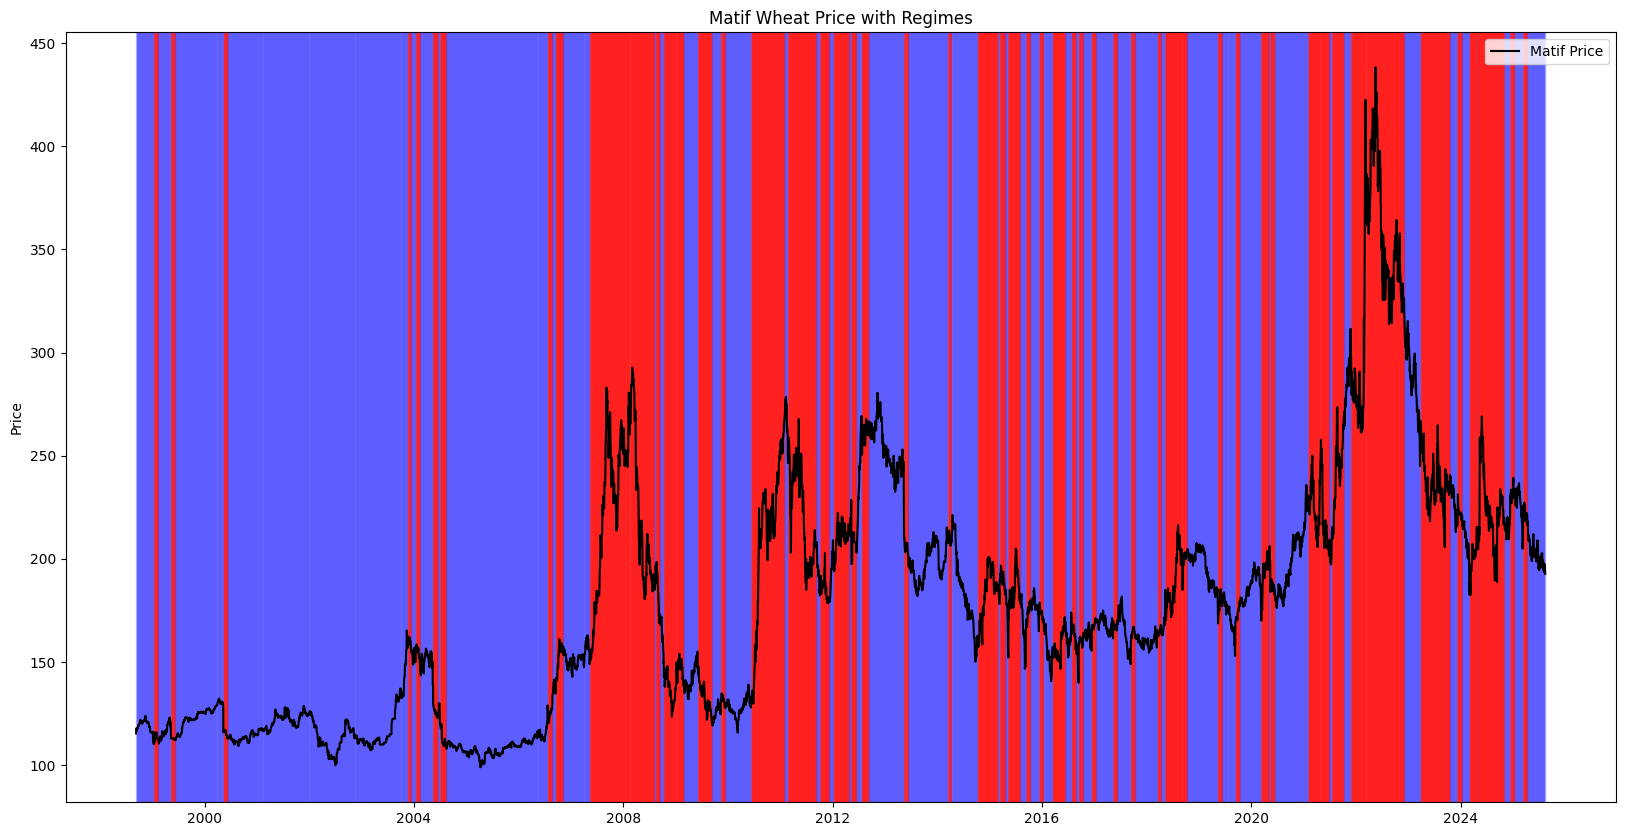

In [6]:
import matplotlib.pyplot as plt

# Make sure price & regime are aligned
price_plot = price.reindex(regime.index).dropna()
regime_plot = regime.reindex(price_plot.index)

plt.figure(figsize=(20,10))

# Plot wheat price
plt.plot(price_plot.index, price_plot.values, color='black', linewidth=1.5, label="Matif Price")

# Overlay calm vs vol with background shading
for start, end in zip(regime_plot.index[:-1], regime_plot.index[1:]):
    if regime_plot.loc[start] == 'VOL':
        plt.axvspan(start, end, color='red', alpha=0.2)
    elif regime_plot.loc[start] == 'CALM':
        plt.axvspan(start, end, color='blue', alpha=0.1)

plt.title("Matif Wheat Price with Regimes")
plt.ylabel("Price")
plt.legend()
plt.show()


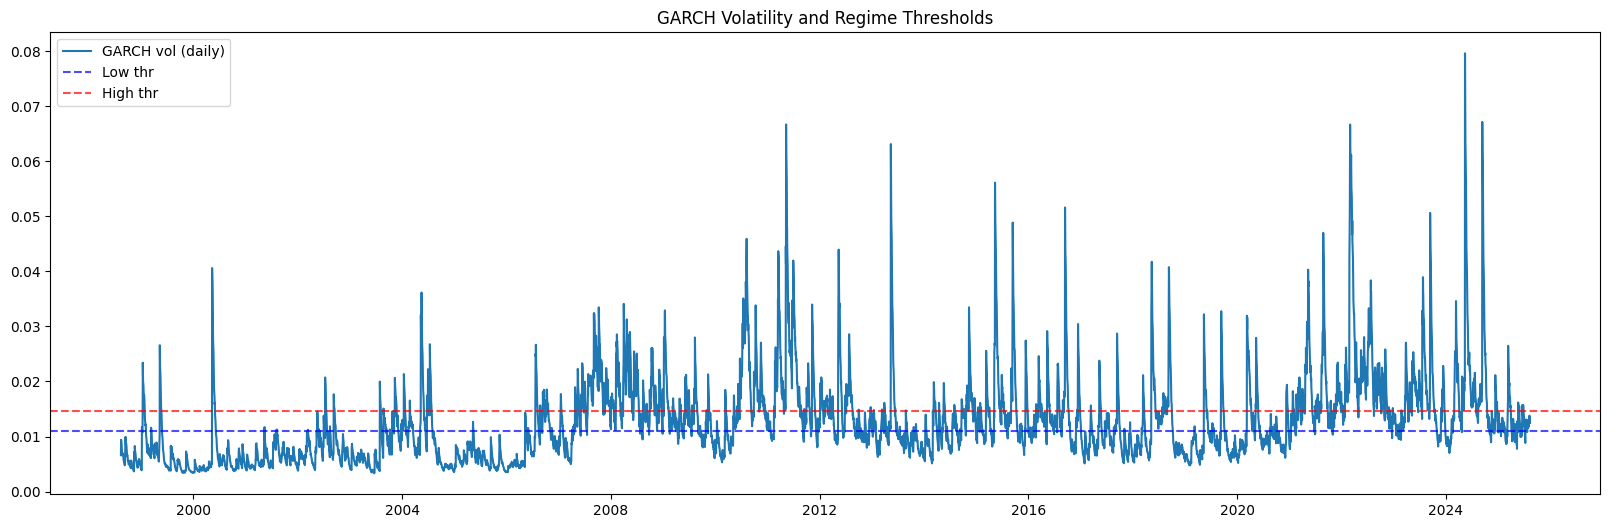

In [7]:
plt.figure(figsize=(20,6))
plt.plot(vol_garch.index, vol_garch, label="GARCH vol (daily)")
plt.axhline(low_thr, color='blue', linestyle='--', alpha=0.7, label="Low thr")
plt.axhline(high_thr, color='red', linestyle='--', alpha=0.7, label="High thr")
plt.legend()
plt.title("GARCH Volatility and Regime Thresholds")
plt.show()


In [8]:
def make_horizon_target(price: pd.Series, horizon: int = 5, kind: str = "pct") -> pd.Series:
    """
    Compute horizon-h forward returns:
    r_{t,h} = log(P_{t+h}/P_t) or (P_{t+h}-P_t)/P_t
    """
    if kind == "log":
        r = np.log(price.shift(-horizon) / price)
    elif kind == "pct":
        r = (price.shift(-horizon) - price) / price
    else:
        raise ValueError("kind must be 'log' or 'pct'")
    return r.rename(f'ret_h{horizon}')

def make_supervised_df_horizon(df: pd.DataFrame,
                               price_col: str = 'Matif_Prices',
                               horizon: int = 5,
                               return_kind: str = 'pct') -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)
    
    # --- target ---
    price = df[price_col]
    out[f'ret_h{horizon}'] = make_horizon_target(price, horizon=horizon, kind=return_kind)
    
    # --- lagged returns (short-term memory) ---
    if return_kind == "log":
        ret_1d = np.log(price / price.shift(1))
    elif return_kind == "pct":
        ret_1d = (price.shift(1) / price) / price
    ret_1d = np.log(price / price.shift(1))
    for L in [1, 2, 3, 5, 10, 20]:
        out[f'ret_lag_{L}'] = ret_1d.shift(L)
    
    # --- rolling stats of daily returns ---
    for W in [5, 10, 20, 60]:
        out[f'ret_rollmean_{W}'] = ret_1d.shift(1).rolling(W).mean()
        out[f'ret_rollstd_{W}']  = ret_1d.shift(1).rolling(W).std()
    
    # Price momentum (moving average gap)
    ma_fast = price.shift(1).rolling(10).mean()
    ma_slow = price.shift(1).rolling(30).mean()
    out['ma_gap_10_30'] = (ma_fast - ma_slow) / ma_slow
    
    # --- macro deltas/z-scores ---
    macro_cols = [c for c in df.columns if c not in {price_col}]
    for c in macro_cols:
        s = df[c]
        out[f'{c}_d1']  = s.diff(1).shift(1)
        out[f'{c}_d5']  = s.diff(5).shift(1)
    
    # --- calendar features ---
    out['dow'] = out.index.dayofweek
    out['month'] = out.index.month
    out['quarter'] = out.index.quarter
    out = pd.get_dummies(out, columns=['dow','month','quarter'], drop_first=True)

    return out.dropna()


In [9]:
supervised_h = make_supervised_df_horizon(df, 'Matif_Prices', horizon=horizon)

# Keep only rows where we have a regime label (and align indexes)
supervised_h = supervised_h.join(regime.rename('regime'), how='inner').dropna(subset=['regime'])
# supervised_h = supervised_h.join(regime_garch.rename('regime'), how='inner').dropna(subset=['regime'])


supervised = supervised_h.join(ohlcv_feats, how='left')

In [10]:
df_weather_no_raw = df_weather.drop(columns=["tmean", "tmin", "tmax", "precip_mm"])
supervised_w = supervised_h.join(df_weather_no_raw, how='left')

In [11]:
# Chronological split
n_train = int(len(supervised_w)*0.8)
train = supervised_w.iloc[:n_train].copy()
test  = supervised_w.iloc[n_train:].copy()

X_cols = [c for c in supervised_w.columns if c not in {f'ret_h{horizon}', 'regime'}]
y_col  = f'ret_h{horizon}'

X_train, y_train, R_train = train[X_cols], train[y_col], train['regime']
X_test,  y_test,  R_test  = test[X_cols],  test[y_col],  test['regime']

# Split by regime
Xtr_calm, ytr_calm = X_train[R_train=='CALM'], y_train[R_train=='CALM']
Xtr_vol,  ytr_vol  = X_train[R_train=='VOL'],  y_train[R_train=='VOL']

In [12]:
from xgboost import XGBRegressor

model_calm = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=8,
    subsample=0.7,
    colsample_bytree=0.6,
    reg_lambda=5,
    reg_alpha=1,
    random_state=42
)
model_calm.fit(Xtr_calm, ytr_calm)

model_vol = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.6,
    reg_lambda=5,
    reg_alpha=1,
    random_state=42
)
model_vol.fit(Xtr_vol, ytr_vol)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


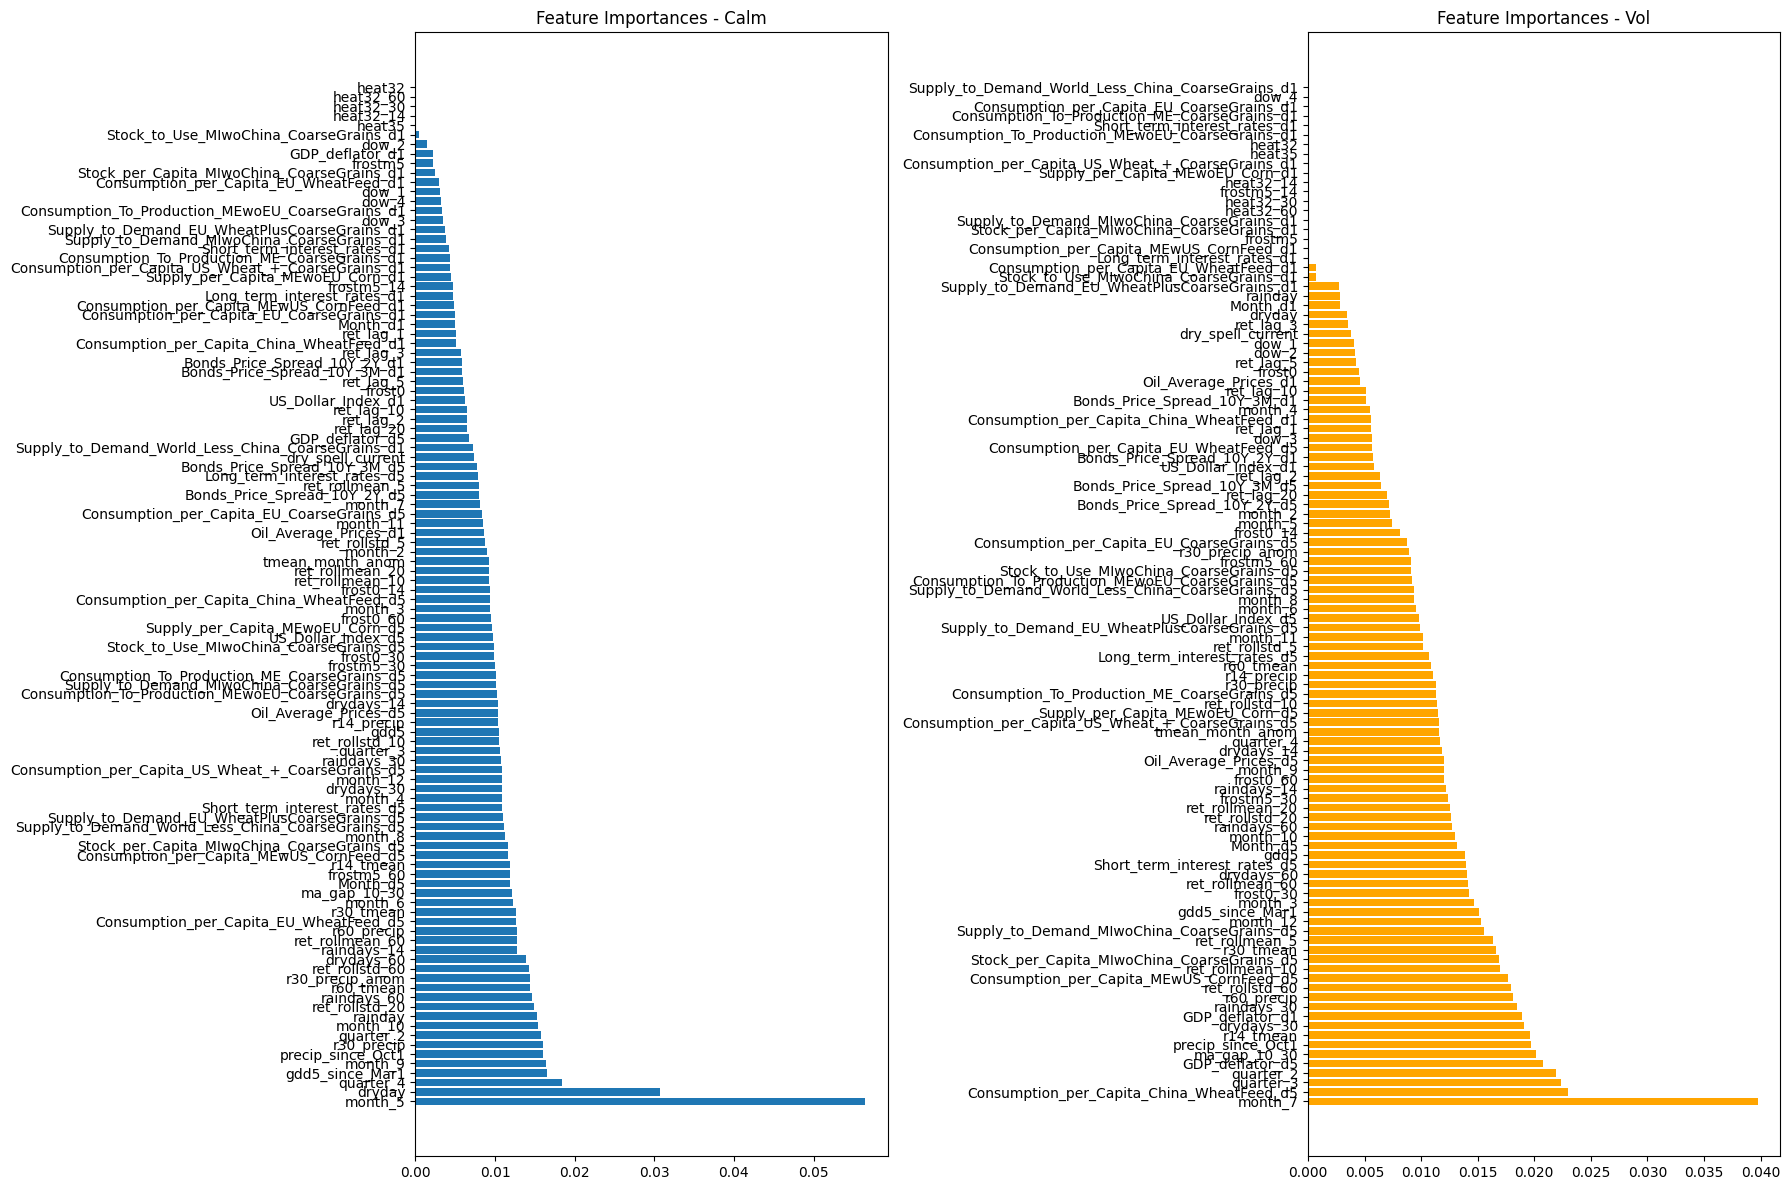

In [13]:
importances_calm = model_calm.feature_importances_
features_calm = Xtr_calm.columns
indices_calm = np.argsort(importances_calm)

importances_vol = model_vol.feature_importances_
features_vol = Xtr_vol.columns
indices_vol = np.argsort(importances_vol)

fig, axes = plt.subplots(1, 2, figsize=(18, 12), sharey=False)
# Calm plot
axes[0].barh(range(len(importances_calm)), importances_calm[indices_calm], align="center")
axes[0].set_yticks(range(len(importances_calm)))
axes[0].set_yticklabels(features_calm[indices_calm])
axes[0].set_title("Feature Importances - Calm")
axes[0].invert_yaxis()  # highest importance at top

# Vol plot
axes[1].barh(range(len(importances_vol)), importances_vol[indices_vol], align="center", color="orange")
axes[1].set_yticks(range(len(importances_vol)))
axes[1].set_yticklabels(features_vol[indices_vol])
axes[1].set_title("Feature Importances - Vol")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
from sklearn.base import clone

def refit_top_features(model, X_train, y_train, X_test, top_n=20, importance_type="gain"):
    booster = model.get_booster()
    imp = pd.Series(booster.get_score(importance_type=importance_type), dtype=float)

    if set(imp.index).issubset({f"f{i}" for i in range(X_train.shape[1])}):
        mapper = {f"f{i}": col for i, col in enumerate(X_train.columns)}
        imp.index = imp.index.map(mapper)

    imp = imp.reindex(X_train.columns).fillna(0.0)

    # Pick top N
    top_features = imp.sort_values(ascending=False).head(top_n).index.tolist()
    print(f"Top {top_n} features:", top_features)

    # Subset data
    Xtr_top = X_train[top_features]
    Xte_top = X_test[top_features]

    # Refit
    model_top = clone(model)
    model_top.fit(Xtr_top, y_train)

    return model_top, Xte_top


model_calm, X_test_calm = refit_top_features(model_calm, Xtr_calm, ytr_calm, X_test, top_n=15)
model_vol,  X_test_vol  = refit_top_features(model_vol,  Xtr_vol, ytr_vol, X_test, top_n=15)

Top 15 features: ['month_5', 'dryday', 'quarter_4', 'gdd5_since_Mar1', 'month_9', 'precip_since_Oct1', 'r30_precip', 'quarter_2', 'month_10', 'rainday', 'ret_rollstd_20', 'raindays_60', 'r60_tmean', 'r30_precip_anom', 'ret_rollstd_60']
Top 15 features: ['month_7', 'Consumption_per_Capita_China_WheatFeed_d5', 'quarter_3', 'quarter_2', 'GDP_deflator_d5', 'ma_gap_10_30', 'precip_since_Oct1', 'r14_tmean', 'drydays_30', 'GDP_deflator_d1', 'raindays_30', 'r60_precip', 'ret_rollstd_60', 'Consumption_per_Capita_MEwUS_CornFeed_d5', 'ret_rollmean_10']


In [15]:
def predict_dual_hard(X, X_c, X_v, regime_series):
    pred = pd.Series(index=X.index, dtype=float)
    idx_calm = (regime_series == 'CALM')
    idx_vol  = (regime_series == 'VOL')
    if idx_calm.any():
        pred.loc[idx_calm] = model_calm.predict(X_c.loc[idx_calm])
    if idx_vol.any():
        pred.loc[idx_vol]  = model_vol.predict(X_v.loc[idx_vol])
    return pred

y_pred_hard = predict_dual_hard(X_test, X_test_calm, X_test_vol, R_test)

# def predict_dual_hard(X, regime_series):
#     pred = pd.Series(index=X.index, dtype=float)
#     idx_calm = (regime_series == 'CALM')
#     idx_vol  = (regime_series == 'VOL')
#     if idx_calm.any():
#         pred.loc[idx_calm] = model_calm.predict(X.loc[idx_calm])
#     if idx_vol.any():
#         pred.loc[idx_vol]  = model_vol.predict(X.loc[idx_vol])
#     return pred

# y_pred_hard = predict_dual_hard(X_test, R_test)

def soft_weight(v, low, high):
    # map vol in [low, high] -> weight in [0,1]; below low→0 (CALM), above high→1 (VOL)
    if v <= low:  return 0.0
    if v >= high: return 1.0
    return float((v - low) / (high - low))

# gather the same vol_ref used for regimes over the test window (remember shift(1) logic)
vol_t_minus1 = vol_daily.shift(1).reindex(X_test.index).ffill()

def predict_dual_soft(X_c, X_v, vol_series, low=low_thr, high=high_thr):
    pred_calm = pd.Series(model_calm.predict(X_c), index=X_c.index)
    pred_vol  = pd.Series(model_vol.predict(X_v),  index=X_v.index)
    w = vol_series.apply(lambda v: soft_weight(v, low, high))
    return (1 - w) * pred_calm + w * pred_vol

y_pred_soft = predict_dual_soft(X_test_calm, X_test_vol, vol_t_minus1)

# def predict_dual_soft(X, vol_series, low=low_thr, high=high_thr):
#     pred_calm = pd.Series(model_calm.predict(X), index=X.index)
#     pred_vol  = pd.Series(model_vol.predict(X),  index=X.index)
#     w = vol_series.apply(lambda v: soft_weight(v, low, high))
#     return (1 - w) * pred_calm + w * pred_vol

# y_pred_soft = predict_dual_soft(X_test, vol_t_minus1)

y_pred = y_pred_soft

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import binomtest

def evaluate_signal(y_test, y_pred, horizon=10, exclude_zeros=False):
    # Core regression-style metrics
    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    corr = np.corrcoef(y_test, y_pred)[0, 1]

    # Directional accuracy
    sign_true = np.sign(y_test)
    sign_pred = np.sign(y_pred)

    if exclude_zeros:
        mask = (sign_true != 0) & (sign_pred != 0)
        sign_true = sign_true[mask]
        sign_pred = sign_pred[mask]

    n_predictions = len(sign_true)
    k_success = np.sum(sign_true == sign_pred)
    hit_rate = k_success / n_predictions if n_predictions > 0 else np.nan

    # Binomial test: H0 p=0.5 vs H1 p>0.5 (one-sided)
    if n_predictions > 0:
        bt = binomtest(k_success, n_predictions, p=0.5, alternative='greater')
        p_value = bt.pvalue
        # Exact (Clopper-Pearson) CI for the true accuracy
        ci = bt.proportion_ci(confidence_level=0.95, method="exact")
    else:
        p_value, ci = np.nan, (np.nan, np.nan)

    # Report
    print(f"Horizon: {horizon}-day")
    print(f"RMSE: {rmse:.5f}, MAE: {mae:.5f}")
    print(f"Correlation: {corr:.3f}")
    print(f"Directional accuracy: {hit_rate:.2%}  "
          f"({k_success}/{n_predictions} correct; exclude_zeros={exclude_zeros})")
    print(f"Binomial test p-value (H1: accuracy > 50%): {p_value:.6f}")
    print(f"95% CI for true accuracy: [{ci.low:.2%}, {ci.high:.2%}]")

# --- Example usage ---
evaluate_signal(y_test, y_pred, horizon=horizon, exclude_zeros=False)
evaluate_signal(y_test, y_pred, horizon=horizon, exclude_zeros=True)


Horizon: 10-day
RMSE: 0.00458, MAE: 0.04647
Correlation: -0.018
Directional accuracy: 53.26%  (743/1395 correct; exclude_zeros=False)
Binomial test p-value (H1: accuracy > 50%): 0.007969
95% CI for true accuracy: [51.02%, 100.00%]
Horizon: 10-day
RMSE: 0.00458, MAE: 0.04647
Correlation: -0.018
Directional accuracy: 54.00%  (743/1376 correct; exclude_zeros=True)
Binomial test p-value (H1: accuracy > 50%): 0.001642
95% CI for true accuracy: [51.75%, 100.00%]


In [17]:
def horizon_returns_to_prices(y_pred_ret, actual_prices, horizon=5):
    """
    Convert horizon-h return predictions into forecast prices.
    At time t, forecast = P_t * exp(rhat_{t,h})
    """
    forecast_prices = actual_prices.loc[y_pred_ret.index] * np.exp(y_pred_ret)
    return forecast_prices.rename(f'Price_hat_h{horizon}')

forecast_prices = horizon_returns_to_prices(y_pred, df['Matif_Prices'], horizon)


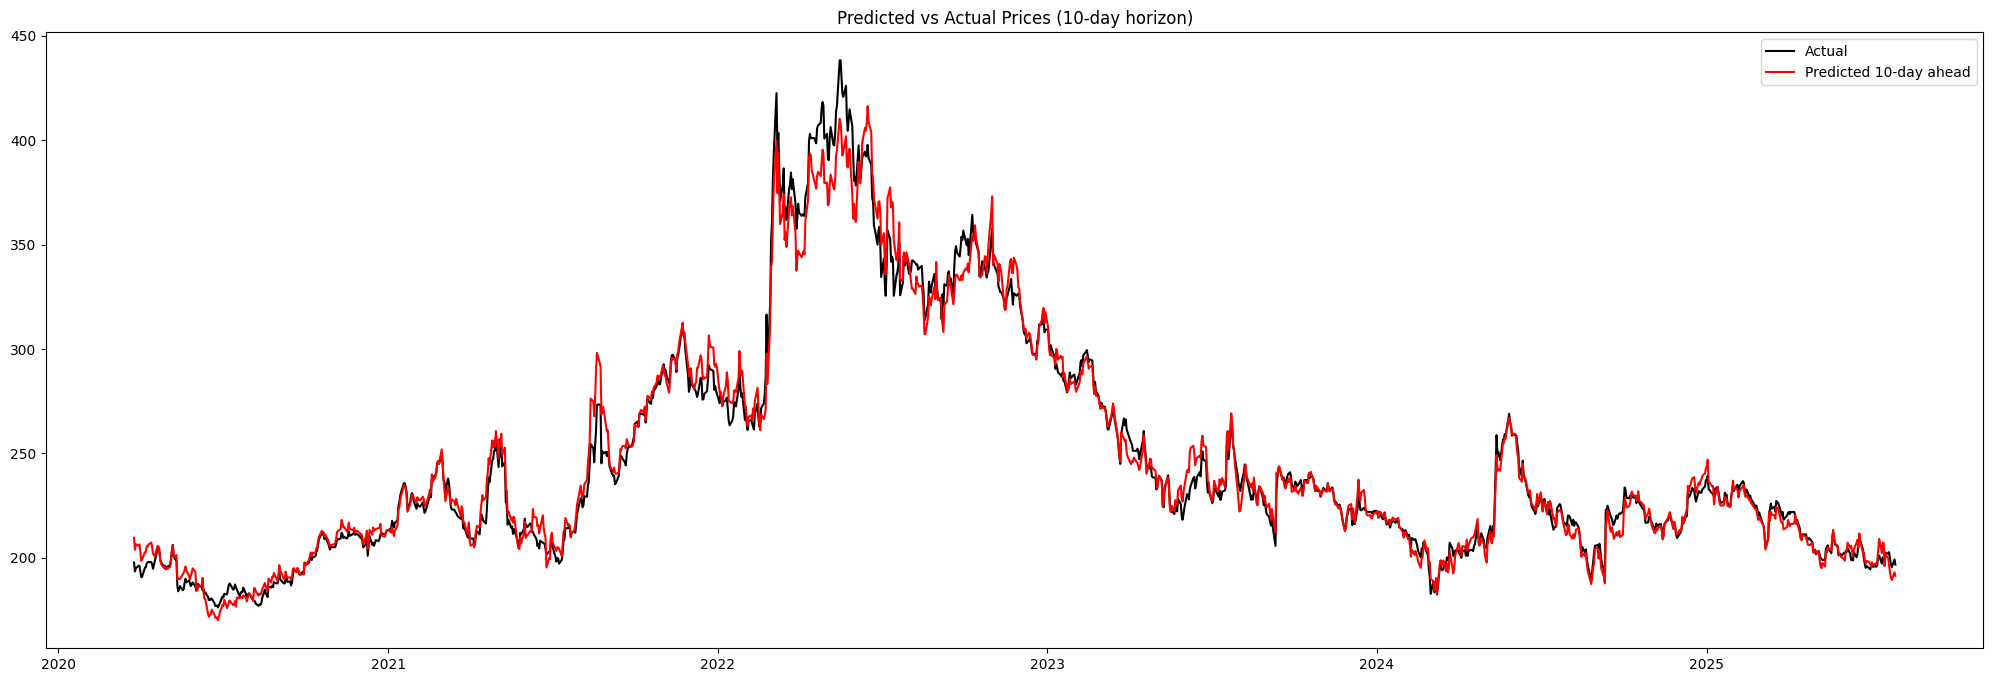

In [18]:
def plot_predicted_vs_actual(df, forecast_prices, horizon, start_date=None, end_date=None):
    idx = forecast_prices.index
    if start_date is not None:
        idx = idx[idx >= pd.to_datetime(start_date)]
    if end_date is not None:
        idx = idx[idx <= pd.to_datetime(end_date)]
    plt.figure(figsize=(25,8))
    plt.plot(idx, df.loc[idx, 'Matif_Prices'], label='Actual', color='black')
    plt.plot(idx, forecast_prices.loc[idx], label=f'Predicted {horizon}-day ahead', color='red')
    plt.title(f"Predicted vs Actual Prices ({horizon}-day horizon)")
    plt.legend()
    plt.show()

# Example usage:
plot_predicted_vs_actual(df, forecast_prices, horizon)#, start_date='2023-06-01', end_date='2026-01-01')
